# FLOD goes federated over synthetic data

In this notebook we want to answer the following question:
"Can different clients build a sphere that contains everybody's data?"

## 1. Single client scenario

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

We generate a synthetic dataset and label it as 0.
0 means that is not an outlier.

In [2]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, cluster_std=2.0)
y = [0] * len(X)

In [3]:
X

array([[ 2.1656807 , -3.93513067],
       [ 1.51751337, -3.45113098],
       [ 3.36298948, -4.0158723 ],
       ...,
       [-7.49057787, -4.2752607 ],
       [ 4.74267286,  1.48653394],
       [ 7.14652012, -2.98068183]])

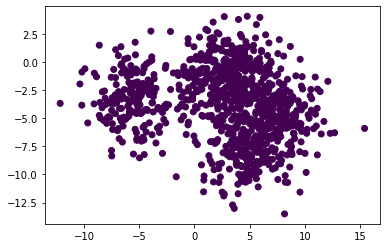

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Let's see if we can create a sphere containing all the points with our implementation of the classifier.

In [5]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [6]:
params = {
    'q': randint(1, 20),
    'c': uniform()    
}
clf = RandomizedSearchCV(BSVClassifier(), params, cv=2, n_jobs=-1, refit='f1', verbose=10, return_train_score=False, n_iter=50)
clf.fit(X, y)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  2.2min remaining:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


Academic license - for non-commercial use only - expires 2021-06-25
Using license file /Users/maxfrax/gurobi.lic
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 1000 columns and 1000 nonzeros
Model fingerprint: 0x91b51b22
Model has 199337 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 1000 columns, 1000 nonzeros
Presolved model has 199337 quadratic objective terms
Ordering time: 0.00s

Barrier stati

RandomizedSearchCV(cv=2, estimator=BSVClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'c': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc54977f250>,
                                        'q': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc5180cb690>},
                   refit='f1', verbose=10)

Theoretically, in the following plot there should be only one color, the one representing the points classified to 0.

c: 0.11507523494275185, q: 1


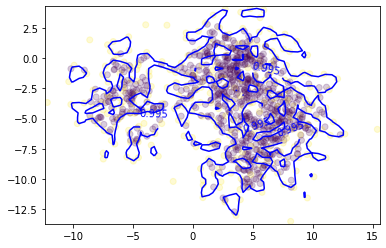

Mistakes 269/1000 = 26.900000000000002%


In [7]:
best_clf = clf.best_estimator_
print(f'c: {best_clf.c}, q: {best_clf.q}')

gx = np.linspace(min(X[:,0])-.2, max(X[:,0])+.2, 50)
gy = np.linspace(min(X[:,1])-.2, max(X[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([best_clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(best_clf.radius_, ), colors='blue')
plt.clabel(membership_contour, inline=1)

plt.scatter(X[:,0], X[:,1], c=best_clf.predict(X), alpha=.2)
plt.show()

mistakes = sum(best_clf.predict(X))
print(f'Mistakes {mistakes}/{len(X)} = {mistakes/len(X)*100}%')

In [8]:
count = 0
for b in best_clf.betas_:
    if not np.isclose(b, 0):
                count+=1
            
print(f'Support vectors are {count}, over {len(X)} candidates')

Support vectors are 974, over 1000 candidates


In [9]:
from joblib import dump, load
dump(clf, 'synth.joblib') 

['synth.joblib']

As we can see a good sphere can be done withouth too much effort.

## 2. Multiple client scenario

Let's split randomly the data generated before among k clients

In [10]:
clients = 5
points_per_client = int(len(X) / clients)

In [11]:
k = [X[i*points_per_client: (i+1)*points_per_client] for i in range(clients)]

colors = [int(i/points_per_client) for i in range(len(X))]

Let's plot again the previous plot, but this time the colors represent the client assignment

c: 0.11507523494275185, q: 1


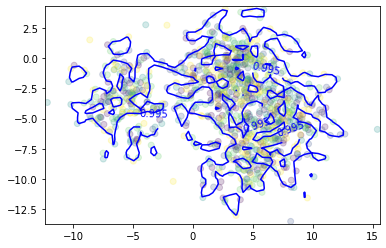

In [12]:
best_clf = clf.best_estimator_
print(f'c: {best_clf.c}, q: {best_clf.q}')

gx = np.linspace(min(X[:,0])-.2, max(X[:,0])+.2, 50)
gy = np.linspace(min(X[:,1])-.2, max(X[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([best_clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(best_clf.radius_, ), colors='blue')
plt.clabel(membership_contour, inline=1)

plt.scatter(X[:,0], X[:,1], c=colors, alpha=.2)
plt.show()

## Federated primitives

### 1. Init server model

In [13]:
def init_server_model():
    return {
        'q': 1,
        'C': 1,
        'betas': np.empty(shape=(0, 2)),
        'xs': np.empty(shape=(0, 2))
    }

### 2. Client update

In [14]:
def client_compute_update(global_model, client_data):
    # Concat points from server and from client
    X = np.concatenate((global_model['xs'], client_data))
    # Init the classifier with q and C from server
    clf = BSVClassifier(q=global_model['q'], c=global_model['C'])
    # Train locally
    clf.fit(X, [0]*len(X))
    # Select only the positive betas related from client_data
    client_betas = clf.betas_[len(global_model['xs']):]
    assert(len(client_betas) == len(client_data))
    
    for i, t in enumerate(zip(client_betas, client_data)):
        b, x = t
        if not np.isclose(b, 0):
            yield x
    

### 3. Server combines client updates

In [15]:
params = {
    'q': randint(1, 20),
    'c': uniform()    
}

def global_combine(global_model, client_updates):
    # Concatenates server points and clients candidate points.
    X = np.concatenate((global_model['xs'], *client_updates))
    
    # Performs model selection over this new dataset
    clf = RandomizedSearchCV(BSVClassifier(), params, cv=2, n_jobs=-1, refit='f1', verbose=10, return_train_score=False, n_iter=50)
    clf.fit(X, [0] * len(X))
    
    # Filter and keep only the support vectors
    xs = []
    betas = []
    for i, t in enumerate(zip(clf.best_estimator_.betas_, X)):
        b, x = t
        if not np.isclose(b, 0):
            xs.append(x)
            betas.append(b)
            
    return {
        'q': clf.best_estimator_.q,
        'C': clf.best_estimator_.c,
        'betas': betas,
        'xs': xs
    }, clf.best_estimator_

## Federated Learning simulation

In [16]:
import threading

number_of_rounds = 20

server_model = init_server_model()

# Metrics
debug_sk_models = []
debug_models = []
mistakes = []

points_per_round = int(points_per_client / number_of_rounds)

def client_worker(client, round_ix):
    dataset = k[client]
    dataset = dataset[points_per_round*round_ix : points_per_round*(round_ix+1),:]
    update = client_compute_update(server_model, dataset)
    client_updates.append(np.array(list(update)))

for r in tqdm(range(number_of_rounds)):
    client_updates = []

    threads = []
    for client in range(clients):
        t = threading.Thread(target=client_worker, args=(client, r))
        threads.append(t)
        t.start()
        
    for t in threads:
        t.join()
        
    server_model, debug_model = global_combine(server_model, client_updates)
    mistakes.append(sum(debug_model.predict(X)))
    debug_models.append(server_model)
    debug_sk_models.append(debug_model)

  0%|          | 0/20 [00:00<?, ?it/s]

Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
Changed value of parameter ObjScale to -0.5
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter NumericFocus to 3
Changed value of parameter NumericFocus to 3
Changed value of parameter DisplayInterval to 1
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Changed value of paramet

   5   9.83238592e-01  1.82552063e+02  1.18e-01 7.99e-12  1.02e+01     0s
   7   8.80148628e-01  3.72663366e+00  1.37e-03 3.66e-14  1.43e-01     0s
   5   9.87483813e-01  1.84174580e+02  1.19e-01 7.19e-12  1.03e+01     0s
   6   8.94944542e-01  2.09428490e+01  1.18e-02 7.94e-13  1.01e+00     0s
   7   8.90122330e-01  3.13259653e+00  1.22e-03 5.18e-14  1.12e-01     0s
   6   8.84808962e-01  2.07681254e+01  1.17e-02 7.92e-13  1.01e+00     0s
   8   8.80004764e-01  1.22599434e+00  1.59e-04 4.25e-15  1.73e-02     0s
   7   8.85669543e-01  2.94470178e+00  1.19e-03 7.99e-14  1.03e-01     0s
   8   8.92222912e-01  1.15499305e+00  1.25e-04 5.33e-15  1.31e-02     0s
   6   8.87953317e-01  2.09826418e+01  1.18e-02 7.12e-13  1.02e+00     0s
   7   8.75791728e-01  2.93601737e+00  1.18e-03 8.02e-14  1.03e-01     0s
   9   8.81981289e-01  9.21724063e-01  1.67e-05 4.44e-16  1.99e-03     0s
   7   8.78669713e-01  2.95571765e+00  1.20e-03 7.21e-14  1.04e-01     0s
   9   8.96971673e-01  9.30911248e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0581s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1836s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 50 columns and 50 nonzeros
Model fingerprint: 0x69eb6795
Model has 538 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 50 columns, 50 nonzeros
Presolved model has 538 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 49
 AA' NZ     : 8.130e+02
 Factor NZ  : 9.980e+02
 Factor Ops : 2.607e+04 (less than 1 second per iterati

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


   9   9.64648764e-01  1.30393283e+00  5.45e-05 3.86e-07  3.39e-03     0s
  10   9.67743421e-01  1.00971989e+00  6.00e-06 4.24e-08  4.20e-04     0s
  11   9.68600649e-01  9.73617167e-01  6.27e-07 4.44e-09  5.02e-05     0s
  12   9.68804747e-01  9.69449823e-01  7.01e-08 4.96e-10  6.45e-06     0s
  13   9.68856412e-01  9.68943509e-01  8.14e-09 5.76e-11  8.71e-07     0s
  14   9.68868231e-01  9.68877862e-01  8.10e-10 5.73e-12  9.63e-08     0s
  15   9.68869657e-01  9.68870677e-01  8.03e-11 5.68e-13  1.02e-08     0s
  16   9.68869797e-01  9.68869904e-01  7.95e-12 5.59e-14  1.07e-09     0s
  17   9.68869810e-01  9.68869821e-01  7.86e-13 5.99e-15  1.07e-10     0s

Barrier solved model in 17 iterations and 0.01 seconds
Optimal objective 9.68869810e-01

Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0 

   0  -1.77623139e+05  2.64310263e+05  5.95e+04 4.71e+02  1.00e+06     0s
   2   5.82033040e+02  2.65418901e+04  5.99e+02 3.52e+00  1.02e+04     0s
   7   9.73165108e-01  3.70249524e+01  6.13e-03 3.40e-05  3.01e-01     0s
   1   3.56086372e+03  2.95557104e+04  5.95e+03 4.71e+01  1.00e+05     0s
   9   9.65532474e-01  1.37941965e+00  6.65e-05 3.55e-07  3.45e-03     0s
   3   6.01858318e+01  2.46673864e+04  5.94e+01 3.49e-01  1.15e+03     0s
   2   5.69962452e+02  2.69877874e+04  5.94e+02 4.71e+00  1.02e+04     0s
   8   9.67735102e-01  4.62758923e+00  6.17e-04 3.42e-06  3.05e-02     0s
   3   5.94437206e+01  2.50465483e+04  5.89e+01 4.66e-01  1.16e+03     0s
   4   6.84993952e+00  1.37364822e+04  5.89e+00 3.46e-02  1.86e+02     0s
  10   9.69735352e-01  1.02375079e+00  7.67e-06 4.10e-08  4.50e-04     0s
   2   5.69959987e+02  2.69877993e+04  5.94e+02 4.71e+00  1.02e+04     0s
   9   9.67951273e-01  1.37297760e+00  6.55e-05 3.63e-07  3.38e-03     0s
   4   6.77316108e+00  1.38250136e+04 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1197s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 100 columns and 100 nonzeros
Model fingerprint: 0x48983988
Model has 2094 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 100 columns, 100 nonzeros
Presolved model has 2094 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 3.935e+03
 Factor NZ  : 4.780e+03
 Factor Ops : 2.941e+05 (less than 1 second per i

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 109 columns and 109 nonzeros
Model fingerprint: 0x11ff139b
Model has 2518 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
Changed value of parameter ObjScale to -0.5
  Bounds range     [8e-01, 8e-01]
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  RHS range        [1e+00, 1e+00]
Changed value of parameter NumericFocus to 3
Changed value of parameter ObjScale to -0.5
   Prev: 0  Min: 0  Max: 3  Default: 0
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Preso

   3   1.08763620e+02  7.45394917e+04  1.08e+02 6.88e-01  1.26e+03     0s
                  Objective                Residual
   5   2.03342309e+00  3.96184279e+03  1.06e+00 6.60e-03  2.25e+01     0s
  18   9.78930359e-01  9.78930363e-01  2.52e-13 8.73e-16  1.78e-11     0s
   4   1.16837817e+01  2.91337429e+04  1.07e+01 6.35e-02  1.98e+02     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time

   6   1.07660982e+00  5.89392674e+02  1.05e-01 6.54e-04  2.83e+00     0s
   4   1.16847645e+01  2.91372748e+04  1.07e+01 6.82e-02  1.98e+02     0s
   0  -2.51367429e+05  4.46879611e+05  1.09e+05 7.12e+02  1.00e+06     0s
Barrier solved model in 18 iterations and 0.25 seconds
   1   7.27141084e+03  9.00229418e+04  1.09e+04 7.12e+01  1.00e+05     0s
   5   2.03341789e+00  3.96157906e+03  1.06e+00 6.76e-03  2.24e+01     0s
   5   2.03414695e+00  3.96104142e+03  1.06e+00 6.29e-03  2.24e+01     0s
   7   9.81790347e-01  6.16535152e+01  1.04e-02 6.48e-05  2.80e-01     0s
Opti

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 149 columns and 149 nonzeros
Model fingerprint: 0x86b23f66
Model has 4704 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 149 columns, 149 nonzeros
Presolved model has 4704 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 148
 AA' NZ     : 9.036e+03
 Factor NZ  : 1.005e+04
 Factor Ops : 8.665e+05 (less than 1 second per 

Presolved: 1 rows, 159 columns, 159 nonzeros
   2   1.57292941e+03  7.26647094e+04  1.59e+03 3.43e+00  1.02e+04     0s
Presolved model has 5415 quadratic objective terms
Presolved model has 5261 quadratic objective terms
Presolved model has 5236 quadratic objective terms
   5   2.55600917e+00  5.44325774e+03  1.58e+00 2.85e-03  2.19e+01     0s
   3   1.58909122e+02  6.71547876e+04  1.58e+02 3.41e-01  1.16e+03     0s
Ordering time: 0.00s
Ordering time: 0.00s
Ordering time: 0.00s
   4   1.66412251e+01  3.57319606e+04  1.57e+01 3.38e-02  1.85e+02     0s
   6   1.13154122e+00  8.46751674e+02  1.57e-01 2.82e-04  2.86e+00     0s



Barrier statistics:
Barrier statistics:
   5   2.52726231e+00  5.36634772e+03  1.55e+00 3.35e-03  2.15e+01     0s
   7   9.90376799e-01  9.10291501e+01  1.55e-02 2.79e-05  2.85e-01     0s
Barrier statistics:
 Free vars  : 158
 Free vars  : 158
 Free vars  : 158
   8   9.76426296e-01  1.00490747e+01  1.55e-03 2.79e-06  2.86e-02     0s
   6   1.12841971e+00  8.34398

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 199 columns and 199 nonzeros
Model fingerprint: 0x6726c5ed
Model has 8075 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 199 columns, 199 nonzeros
Presolved model has 8075 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 198
 AA' NZ     : 1.559e+04
 Factor NZ  : 1.820e+04
 Factor Ops : 2.128e+06 (less than 1 second per 

Presolved: 1 rows, 201 columns, 201 nonzeros
   7   9.96930549e-01  1.28617600e+02  1.08e-02 4.31e-05  3.21e-01     0s
 Factor Ops : 2.255e+06 (less than 1 second per iteration)
Presolved model has 8466 quadratic objective terms
 Threads    : 8
Presolved model has 8191 quadratic objective terms
 Threads    : 1
   8   9.77579004e-01  1.38116678e+01  1.07e-03 4.29e-06  3.20e-02     0s

Ordering time: 0.00s
   9   9.75900326e-01  2.32409043e+00  1.11e-04 4.45e-07  3.35e-03     0s
                  Objective                Residual
Ordering time: 0.00s


Iter       Primal          Dual         Primal    Dual     Compl     Time

                  Objective                Residual
Barrier statistics:
  10   9.77910435e-01  1.15477681e+00  1.33e-05 5.31e-08  4.40e-04     0s
Barrier statistics:
   0  -2.50982105e+05  6.13881724e+05  1.01e+05 9.03e+02  1.00e+06     0s
Iter       Primal          Dual         Primal    Dual     Compl     Time
 Free vars  : 200
 Free vars  : 200
 AA' NZ     : 1.62

  18   9.84317043e-01  9.84317847e-01  1.21e-11 1.17e-13  2.00e-09     0s
  19   9.84317188e-01  9.84317284e-01  1.21e-12 1.15e-14  2.38e-10     0s
  20   9.84317205e-01  9.84317215e-01  1.20e-13 1.11e-15  2.39e-11     0s

Barrier solved model in 20 iterations and 0.25 seconds
Optimal objective 9.84317205e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    8.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 238 columns and 238 nonzeros
Model fingerprint: 0x00db956d
Model has 12097 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 238 columns, 238 nonzeros
Presolved model has 12097 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 237
 AA' NZ     : 2.406e+04
 Factor NZ  : 2.720e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.07

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 245 columns and 245 nonzeros
Model fingerprint: 0x45066385
Model has 12648 quadratic objective terms
  21   9.84843132e-01  9.84843137e-01  2.21e-15 2.22e-16  9.71e-12     1s
  12   9.84052786e-01  9.96925324e-01  3.14e-07 3.70e-09  2.63e-05     0s
Coefficient statistics:

  Matrix range     [1e+00, 1e+00]
Changed value of parameter ObjScale to -0.5
Barrier solved model in 21 iterations and 0.53 seconds
  13   9.84754293e-01  9.86874478e-01  3.86e-08 4.55e-10  4.33e-06     0s
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
Changed value of parameter NumericFocus to 3
Optimal objective 9.84843132e-01

   Prev: 0  Min: 0  Max: 3  Default: 0
  Bounds range     [5e-01, 5e-01]
  14   9.84884393e-01  9.85300444e-01  5.85e-09 6.89e-11  8.49e-07     0s
  RHS range        [1e+00, 1e+00]
Changed value of parameter DisplayInt

  15   9.85030744e-01  9.85113521e-01  8.93e-10 9.65e-12  1.69e-07     0s
  13   9.84484635e-01  9.88548595e-01  3.43e-08 2.74e-10  8.29e-06     0s
  16   9.85042395e-01  9.85069379e-01  2.45e-10 2.65e-12  5.51e-08     0s
  14   9.84729417e-01  9.85450200e-01  4.59e-09 3.66e-11  1.47e-06     0s
  17   9.85047321e-01  9.85053870e-01  4.73e-11 5.12e-13  1.34e-08     0s
  18   9.85048584e-01  9.85050022e-01  9.69e-12 1.05e-13  2.93e-09     0s
  15   9.84785869e-01  9.84939799e-01  7.65e-10 6.11e-12  3.14e-07     0s
  19   9.85048915e-01  9.85049147e-01  1.42e-12 1.50e-14  4.73e-10     0s
  16   9.84803202e-01  9.84851842e-01  2.15e-10 1.71e-12  9.93e-08     0s
  20   9.85048971e-01  9.85049018e-01  2.60e-13 2.58e-15  9.45e-11     0s
  17   9.84811160e-01  9.84827056e-01  4.23e-11 3.37e-13  3.24e-08     0s
  21   9.85048984e-01  9.85048989e-01  2.60e-14 2.22e-16  9.80e-12     0s

Barrier solved model in 21 iterations and 0.30 seconds
  18   9.84813663e-01  9.84817991e-01  1.04e-11 8.39e-14

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   11.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 282 columns and 282 nonzeros
Model fingerprint: 0x869a7cf2
Model has 17192 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 282 columns, 282 nonzeros
Presolved model has 17192 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 281
 AA' NZ     : 3.505e+04
 Factor NZ  : 3.674e+04 (roughly 1 MByte of memory)
 Factor Ops : 6.26

 Factor Ops : 7.005e+06 (less than 1 second per iteration)
Ordering time: 0.00s
 Factor NZ  : 3.905e+04 (roughly 1 MByte of memory)
Barrier statistics:
   1   2.66511467e+04  2.49473824e+05  1.47e+04 5.36e+01  1.00e+05     0s
 Threads    : 8
 Free vars  : 291
 Factor Ops : 6.798e+06 (less than 1 second per iteration)
 AA' NZ     : 3.832e+04
 Threads    : 8
 Factor NZ  : 4.108e+04 (roughly 1 MByte of memory)

Barrier statistics:
 Factor Ops : 7.653e+06 (less than 1 second per iteration)
 Free vars  : 291
 Threads    : 8
 AA' NZ     : 3.811e+04

                  Objective                Residual
 Factor NZ  : 4.134e+04 (roughly 1 MByte of memory)
Iter       Primal          Dual         Primal    Dual     Compl     Time

 Factor Ops : 7.727e+06 (less than 1 second per iteration)
                  Objective                Residual
   0   8.28024443e+04  4.57130374e+05  2.91e+05 4.14e+02  1.00e+06     0s
 Threads    : 8
   2   3.00684886e+03  2.43158495e+05  1.52e+03 5.54e+00  1.07e+04    

  21   9.85879871e-01  9.85879880e-01  7.36e-14 4.20e-16  1.65e-11     0s
  20   9.85803636e-01  9.85803659e-01  2.47e-13 3.76e-16  4.00e-11     0s

  18   9.85800138e-01  9.85801029e-01  7.63e-12 1.08e-14  1.53e-09     0s
  22   9.86078676e-01  9.86078678e-01  1.45e-14 3.21e-16  4.37e-12     0s
Barrier solved model in 21 iterations and 0.24 seconds

Optimal objective 9.85879871e-01
Barrier solved model in 22 iterations and 0.40 seconds

Optimal objective 9.86078676e-01

  19   9.85800284e-01  9.85800519e-01  1.80e-12 2.47e-15  4.03e-10     0s
  16   9.85840104e-01  9.85845008e-01  5.40e-11 7.67e-14  8.40e-09     0s
  21   9.85803641e-01  9.85803643e-01  2.24e-14 2.22e-16  4.01e-12     0s

Barrier solved model in 21 iterations and 0.26 seconds
  20   9.85800328e-01  9.85800367e-01  2.77e-13 3.81e-16  6.60e-11     0s
Optimal objective 9.85803641e-01
  17   9.85841519e-01  9.85842502e-01  8.06e-12 1.14e-14  1.68e-09     0s

  21   9.85800336e-01  9.85800340e-01  2.75e-14 2.22e-16  6.72e-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   14.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 326 columns and 326 nonzeros
Model fingerprint: 0x4101ecfa
Model has 23553 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [4e-01, 4e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 326 columns, 326 nonzeros
Presolved model has 23553 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 325
 AA' NZ     : 4.471e+04
 Factor NZ  : 4.827e+04 (roughly 1 MByte of memory)
 Factor Ops : 9.44

   7   1.00492090e+00  1.71870824e+02  3.09e-02 4.06e-05  2.69e-01     0s
Presolve time: 0.14s
   1   2.99578282e+04  1.39399415e+05  3.21e+04 4.22e+01  1.00e+05     0s
Presolved: 1 rows, 322 columns, 322 nonzeros
Presolve time: 0.14s
Presolved model has 24009 quadratic objective terms
Presolved: 1 rows, 322 columns, 322 nonzeros
Presolved model has 23799 quadratic objective terms
   8   9.77101910e-01  1.81406242e+01  3.08e-03 4.04e-06  2.67e-02     0s
Ordering time: 0.00s
   2   3.18801135e+03  1.36247900e+05  3.21e+03 4.22e+00  1.02e+04     0s
Ordering time: 0.00s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 322 columns and 322 nonzeros

Model fingerprint: 0xc9bcbcc1
Barrier statistics:
Model has 23471 quadratic objective terms

 Free vars  : 321
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
Barrier statistics:
   9   9.74532273e-01  2.77368758e+00  3.22e-0

  21   9.86381992e-01  9.86381995e-01  2.18e-14 2.22e-16  4.47e-12     1s

Barrier solved model in 21 iterations and 0.56 seconds
  15   9.86214646e-01  9.86284763e-01  1.40e-09 3.21e-12  1.09e-07     0s
Optimal objective 9.86381992e-01

  19   9.86386983e-01  9.86388447e-01  2.94e-12 2.14e-14  2.27e-09     0s
  16   9.86234429e-01  9.86258879e-01  4.92e-10 6.48e-13  3.80e-08     0s
  16   9.86223731e-01  9.86240349e-01  2.27e-10 5.21e-13  2.58e-08     0s
  17   9.86237660e-01  9.86245792e-01  1.32e-10 1.74e-13  1.26e-08     0s
  17   9.86226248e-01  9.86231609e-01  6.25e-11 1.43e-13  8.33e-09     0s
  20   9.86387286e-01  9.86387541e-01  2.91e-13 1.38e-15  3.95e-10     0s
  18   9.86238996e-01  9.86241014e-01  2.45e-11 3.22e-14  3.13e-09     0s
  18   9.86227201e-01  9.86228627e-01  1.36e-11 3.11e-14  2.21e-09     0s
  21   9.86387338e-01  9.86387367e-01  3.03e-14 1.13e-15  4.38e-11     0s
  19   9.86227463e-01  9.86227836e-01  2.52e-12 5.77e-15  5.78e-10     0s
  19   9.86239384e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   18.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0x4c0ed8b5
Model has 18477 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 18477 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 360
 AA' NZ     : 3.700e+04
 Factor NZ  : 4.456e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.75

Coefficient statistics:
  QObjective range [1e-13, 4e+00]
  QObjective range [1e-13, 4e+00]
  Matrix range     [1e+00, 1e+00]
  Bounds range     [8e-01, 8e-01]
  Bounds range     [8e-01, 8e-01]
   1   3.37372722e+04  3.00656170e+05  3.55e+04 3.51e+01  1.00e+05     0s
  RHS range        [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  14   9.91380281e-01  9.91458183e-01  5.91e-09 6.01e-12  1.10e-07     1s
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolve time: 0.01s
Presolved: 1 rows, 355 columns, 355 nonzeros
Presolved model has 17840 quadratic objective terms
Presolved: 1 rows, 355 columns, 355 nonzeros
Presolved model has 17761 quadratic objective terms
Presolve time: 0.01s
Presolved: 1 rows, 355 columns, 355 nonzeros
Presolved model has 17813 quadratic objective terms
   2   3.53411033e+03  2.94460827e+05  3.55e+03 3.51e+00  1.03e+04     1s
Ordering time: 0.00s
Order

  19   9.91315564e-01  9.91315568e-01  8.48e-14 2.22e-16  5.15e-12     0s

  19   9.91332183e-01  9.91332186e-01  8.28e-14 2.22e-16  4.19e-12     0s
Barrier solved model in 19 iterations and 0.32 seconds

Optimal objective 9.91315564e-01
Barrier solved model in 19 iterations and 0.32 seconds

  19   9.91376000e-01  9.91376002e-01  6.33e-14 2.22e-16  3.19e-12     0s
Optimal objective 9.91332183e-01

Barrier solved model in 19 iterations and 0.33 seconds

Optimal objective 9.91376000e-01

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   20.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 390 columns and 390 nonzeros
Model fingerprint: 0xc8418b02
Model has 33390 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 390 columns, 390 nonzeros
Presolved model has 33390 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 389
 AA' NZ     : 6.208e+04
 Factor NZ  : 7.102e+04 (roughly 1 MByte of memory)
 Factor Ops : 1.70

Coefficient statistics:
   7   1.07885827e+00  5.71296589e+02  5.13e-02 7.22e-05  7.53e-01     0s
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
   8   9.86311468e-01  5.98146366e+01  5.09e-03 7.15e-06  7.41e-02     0s
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
   9   9.77210397e-01  6.93110545e+00  5.10e-04 7.17e-07  7.47e-03     0s
Presolve time: 0.16s
Presolved: 1 rows, 399 columns, 399 nonzeros
  10   9.76791707e-01  1.63505367e+00  5.52e-05 7.76e-08  8.25e-04     0s
Presolved model has 34618 quadratic objective terms
Ordering time: 0.00s
  11   9.80865962e-01  1.08717221e+00  8.00e-06 1.12e-08  1.33e-04     1s

Barrier statistics:
 Free vars  : 398
 AA' NZ     : 6.587e+04
Changed value of parameter ObjScale to -0.5
  12   9.85673823e-01  1.00537870e+00  8.22e-07 1.16e-09  2.47e-05     1s
 Factor NZ  : 7.270e+04 (roughly 1 MByte of memory)
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of

  13   9.87005847e-01  9.90318507e-01  8.76e-08 1.28e-10  4.15e-06     0s
  15   9.87326458e-01  9.87414750e-01  1.29e-09 1.82e-12  1.11e-07     0s
  14   9.87189541e-01  9.87723906e-01  9.38e-09 1.37e-11  6.70e-07     0s
  16   9.87337039e-01  9.87354326e-01  1.66e-10 2.35e-13  2.17e-08     0s
  17   9.87340181e-01  9.87344066e-01  2.58e-11 3.64e-14  4.87e-09     0s
  15   9.87226278e-01  9.87315904e-01  1.12e-09 1.64e-12  1.12e-07     0s
  18   9.87341086e-01  9.87342058e-01  4.09e-12 5.84e-15  1.22e-09     0s
  16   9.87237352e-01  9.87254727e-01  1.38e-10 2.02e-13  2.18e-08     0s
  19   9.87341308e-01  9.87341536e-01  8.63e-13 1.29e-15  2.86e-10     1s
  17   9.87240498e-01  9.87244481e-01  2.16e-11 3.17e-14  4.99e-09     0s
  20   9.87341362e-01  9.87341407e-01  1.62e-13 2.81e-16  5.62e-11     1s
  18   9.87241338e-01  9.87242447e-01  4.21e-12 6.28e-15  1.39e-09     0s
  21   9.87341374e-01  9.87341381e-01  2.59e-14 2.22e-16  9.01e-12     1s

  19   9.87241555e-01  9.87241926e-01

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   25.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 438 columns and 438 nonzeros
Model fingerprint: 0x1a2dbbe9
Model has 41176 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 438 columns, 438 nonzeros
Presolved model has 41176 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 437
 AA' NZ     : 8.427e+04
 Factor NZ  : 9.339e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.65


Barrier solved model in 21 iterations and 0.80 seconds
Optimal objective 9.87814316e-01
   3   4.63633173e+02  1.11060996e+05  2.31e+02 2.85e-01  1.16e+03     1s

Ordering time: 0.00s
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
   4   6.25700098e+01  6.38299538e+04  3.08e+01 3.80e-02  1.82e+02     1s
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
   5   7.24717225e+00  1.66679710e+04  3.14e+00 3.87e-03  2.72e+01     1s

Barrier statistics:
 Free vars  : 438
 AA' NZ     : 8.467e+04
   6   1.59839067e+00  2.39855265e+03  3.11e-01 3.83e-04  3.29e+00     1s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
 Factor NZ  : 9.537e+04 (roughly 1 MByte of memory)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
 Factor Ops : 2.762e+07 (less than 1 second per iteration)
 Threads    : 8



  11   9.82297843e-01  1.06352381e+00  6.36e-06 7.86e-09  9.25e-05     0s
  16   9.87791907e-01  9.87824585e-01  8.58e-10 1.49e-12  3.72e-08     1s
  12   9.86779839e-01  1.00336805e+00  6.50e-07 8.03e-10  1.89e-05     0s
  17   9.87795900e-01  9.87803853e-01  1.37e-10 2.38e-13  9.06e-09     1s
  13   9.87823808e-01  9.90835426e-01  8.32e-08 1.03e-10  3.43e-06     0s
  18   9.87797214e-01  9.87798905e-01  1.68e-11 2.91e-14  1.93e-09     1s
  14   9.87952421e-01  9.88570496e-01  1.43e-08 1.77e-11  7.04e-07     0s
  15   9.87978659e-01  9.88141781e-01  3.18e-09 3.93e-12  1.86e-07     1s
  19   9.87797554e-01  9.87797850e-01  1.67e-12 2.96e-15  3.38e-10     1s
  16   9.87989134e-01  9.88039996e-01  7.54e-10 9.33e-13  5.79e-08     1s
  17   9.87993992e-01  9.88005947e-01  1.21e-10 1.50e-13  1.36e-08     1s
  20   9.87797613e-01  9.87797658e-01  1.86e-13 4.53e-16  5.11e-11     1s
  21   9.87797623e-01  9.87797630e-01  1.87e-14 4.44e-16  7.65e-12     1s
  18   9.87995744e-01  9.87998205e-01

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   30.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 476 columns and 476 nonzeros
Model fingerprint: 0xa1c48f7d
Model has 48632 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 476 columns, 476 nonzeros
Presolved model has 48632 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 475
 AA' NZ     : 1.033e+05
 Factor NZ  : 1.117e+05 (roughly 1 MByte of memory)
 Factor Ops : 3.50

Optimize a model with 1 rows, 484 columns and 484 nonzeros
Model fingerprint: 0x22abe6ac
   7   1.22306536e+00  1.54707455e+03  1.26e-02 2.83e-04  1.77e+00     0s
Model has 50079 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
   8   9.97756058e-01  1.79530645e+02  1.26e-03 2.81e-05  1.87e-01     0s
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
   9   9.75345499e-01  1.89128735e+01  1.25e-04 2.80e-06  1.86e-02     0s
  RHS range        [1e+00, 1e+00]
  10   9.73520175e-01  2.84495707e+00  1.29e-05 2.88e-07  1.93e-03     0s
  11   9.76395077e-01  1.21930133e+00  1.53e-06 3.42e-08  2.51e-04     1s
Presolve time: 0.12s
  12   9.83408589e-01  1.03735138e+00  2.69e-07 6.02e-09  5.57e-05     1s
Presolved: 1 rows, 484 columns, 484 nonzeros
  13   9.87461839e-01  9.99644892e-01  2.95e-08 6.61e-10  1.26e-05     1s
Presolved model has 50079 quadratic objective terms
  14   9.88152520e-01  9.91120826e-01  


Barrier solved model in 22 iterations and 1.10 seconds
Optimal objective 9.88344083e-01

  14   9.88052075e-01  9.91177265e-01  8.12e-09 1.25e-10  3.23e-06     1s
  12   9.83909033e-01  1.03169395e+00  2.13e-07 4.95e-09  4.94e-05     1s
  15   9.88210985e-01  9.88898743e-01  1.33e-09 2.04e-11  7.11e-07     1s
  13   9.87556512e-01  9.97079622e-01  2.28e-08 5.31e-10  9.84e-06     1s
  16   9.88242576e-01  9.88442779e-01  3.27e-10 5.02e-12  2.07e-07     1s
  17   9.88253637e-01  9.88321969e-01  9.66e-11 1.48e-12  7.06e-08     1s
  14   9.88138115e-01  9.90121916e-01  3.77e-09 8.75e-11  2.05e-06     1s
  18   9.88258788e-01  9.88282581e-01  2.61e-11 4.10e-13  2.46e-08     1s
  15   9.88223433e-01  9.88637755e-01  6.42e-10 1.49e-11  4.28e-07     1s
  19   9.88261474e-01  9.88267180e-01  2.95e-12 4.43e-14  5.89e-09     1s
  16   9.88243090e-01  9.88370959e-01  1.70e-10 3.95e-12  1.32e-07     1s
  17   9.88251245e-01  9.88294574e-01  4.93e-11 1.15e-12  4.48e-08     1s
  20   9.88262333e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   34.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.0s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 522 columns and 522 nonzeros
Model fingerprint: 0x874f1beb
Model has 58104 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [6e-01, 6e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 522 columns, 522 nonzeros
Presolved model has 58104 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 521
 AA' NZ     : 1.234e+05
 Factor NZ  : 1.355e+05 (roughly 2 MBytes of memory)
 Factor Ops : 4.7

  12   9.84573828e-01  1.03441971e+00  1.83e-07 2.49e-09  4.70e-05     1s
  13   9.87770150e-01  9.97937195e-01  2.02e-08 2.75e-10  9.59e-06     1s
  14   9.88315811e-01  9.90342932e-01  2.96e-09 4.03e-11  1.91e-06     1s
  15   9.88392620e-01  9.88797593e-01  4.95e-10 6.74e-12  3.82e-07     1s
  16   9.88411374e-01  9.88523708e-01  1.05e-10 1.42e-12  1.06e-07     1s
  17   9.88418765e-01  9.88453919e-01  2.57e-11 3.47e-13  3.32e-08     1s
Changed value of parameter ObjScale to -0.5
  18   9.88422213e-01  9.88431270e-01  3.55e-12 5.14e-14  8.54e-09     1s
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
  19   9.88423400e-01  9.88425564e-01  4.42e-13 7.50e-15  2.04e-09     1s
  20   9.88423752e-01  9.88424211e-01  4.93e-14 1.78e-15  4.33e-10     1s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread 

  10   9.74529526e-01  3.12059829e+00  1.24e-05 1.60e-07  2.03e-03     0s
  14   9.88435095e-01  9.90958607e-01  3.17e-09 4.62e-11  2.38e-06     1s
  11   9.76960531e-01  1.25051386e+00  1.47e-06 1.89e-08  2.58e-04     0s
  15   9.88539155e-01  9.89008099e-01  4.52e-10 6.59e-12  4.42e-07     1s
  16   9.88561716e-01  9.88661680e-01  6.83e-11 9.98e-13  9.43e-08     1s
  12   9.84100988e-01  1.03726384e+00  2.13e-07 2.74e-09  5.02e-05     1s
  17   9.88569244e-01  9.88597960e-01  1.52e-11 2.29e-13  2.71e-08     1s
  13   9.87799327e-01  9.98771016e-01  2.32e-08 2.99e-10  1.04e-05     1s
  18   9.88572091e-01  9.88581874e-01  3.45e-12 4.12e-14  9.23e-09     1s
  14   9.88426874e-01  9.90639888e-01  3.42e-09 4.40e-11  2.09e-06     1s
  19   9.88573328e-01  9.88575846e-01  6.44e-13 1.00e-14  2.38e-09     1s
  15   9.88513790e-01  9.88963346e-01  5.57e-10 7.17e-12  4.24e-07     1s
  20   9.88573738e-01  9.88574303e-01  7.33e-14 4.44e-16  5.33e-10     1s
  16   9.88531812e-01  9.88675713e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   40.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.2s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 569 columns and 569 nonzeros
Model fingerprint: 0xe4f37400
Model has 68768 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-02, 5e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 569 columns, 569 nonzeros
Presolved model has 68768 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 568
 AA' NZ     : 1.477e+05
 Factor NZ  : 1.609e+05 (roughly 2 MBytes of memory)
 Factor Ops : 6.0

   8   1.00302730e+00  2.12984233e+02  1.14e-03 4.04e-05  1.86e-01     1s
   9   9.73690444e-01  2.22723266e+01  1.14e-04 4.04e-06  1.84e-02     1s
  10   9.71268218e-01  3.69314936e+00  1.46e-05 5.16e-07  2.35e-03     1s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
  11   9.73278601e-01  1.60496877e+00  3.31e-06 1.17e-07  5.46e-04     1s
Optimize a model with 1 rows, 579 columns and 579 nonzeros
Model fingerprint: 0x72aaf385
Model has 70886 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  12   9.78389685e-01  1.11169351e+00  6.01e-07 2.13e-08  1.15e-04     1s
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-02, 5e-02]
  RHS range        [1e+00, 1e+00]
  13   9.85935344e-01  1.01874136e+00  7.88e-08 2.79e-09  2.83e-05     1s
Presolve time: 0.05s
Presolved: 1 rows, 579 columns, 579 nonzeros
Presolved model has 70886 quadrati

  21   9.88712709e-01  9.88712851e-01  1.15e-14 3.03e-15  1.23e-10     1s
   2   7.23054343e+03  2.66550595e+04  2.63e+02 2.82e+00  1.01e+04     0s
  22   9.88712738e-01  9.88712762e-01  1.56e-15 2.22e-16  2.11e-11     1s
   3   7.54790196e+02  2.64689229e+04  2.77e+01 2.97e-01  1.08e+03     0s
  23   9.88712743e-01  9.88712746e-01  4.56e-16 1.78e-15  2.74e-12     1s

Barrier solved model in 23 iterations and 1.03 seconds
Optimal objective 9.88712743e-01
   4   1.04231626e+02  2.54555535e+04  5.37e+00 5.76e-02  2.21e+02     0s

   5   2.12756992e+01  2.23199476e+04  8.82e-01 9.47e-03  5.14e+01     0s
   6   3.36843867e+00  9.54421234e+03  8.74e-02 9.38e-04  1.10e+01     0s
   7   1.22678942e+00  1.64267606e+03  9.08e-03 9.75e-05  1.56e+00     0s
   8   9.99859181e-01  1.82906892e+02  9.00e-04 9.66e-06  1.59e-01     0s
   9   9.77373846e-01  1.92162224e+01  9.00e-05 9.67e-07  1.58e-02     0s
  10   9.75365245e-01  2.89275014e+00  9.46e-06 1.02e-07  1.66e-03     0s
  11   9.77205044e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   47.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.9s finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 617 columns and 617 nonzeros
Model fingerprint: 0xef7e1f2b
Model has 80131 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 617 columns, 617 nonzeros
Presolved model has 80131 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 612
 AA' NZ     : 1.670e+05
 Factor NZ  : 1.870e+05 (roughly 2 MBytes of memory)
 Factor Ops : 7.6

  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
  22   9.88796227e-01  9.88796270e-01  2.23e-15 3.55e-15  3.43e-11     1s
Presolve time: 0.04s
Presolved: 1 rows, 627 columns, 627 nonzeros
Presolved model has 82598 quadratic objective terms
   4  -2.90174179e+03  3.06333023e+05  1.41e+01 4.09e-01  7.06e+02     1s
  23   9.88796236e-01  9.88796242e-01  7.10e-16 9.78e-15  4.05e-12     1s
Ordering time: 0.00s
   5  -1.85723435e+01  1.66246567e+05  2.45e+00 7.11e-02  2.19e+02     1s

   6   7.85380670e+00  2.20923511e+04  2.43e-01 7.04e-03  2.50e+01     1s
Barrier solved model in 23 iterations and 1.21 seconds
   7   1.73146829e+00  3.05497416e+03  2.43e-02 7.04e-04  3.01e+00     1s

Optimal objective 9.88796236e-01
Barrier statistics:

 Free vars  : 622
 AA' NZ     : 1.743e+05
   8   1.04909321e+00  4.65483411e+02  2.41e-03 6.97e-05  3.86e-01     1s
 Factor NZ  : 1.932e+05 (roughly 2 MBytes of memory)
 Factor Ops : 8.002e+07 (less than 1 second per iteration)
 Threads  

  13   9.87101640e-01  1.00710086e+00  5.20e-08 1.32e-09  1.59e-05     1s
  10   9.74548190e-01  4.48317281e+00  1.64e-05 4.82e-07  2.80e-03     1s
  22   9.88931240e-01  9.88931301e-01  2.79e-15 2.22e-16  4.81e-11     2s
  14   9.88543086e-01  9.92519021e-01  7.09e-09 1.80e-10  3.17e-06     1s
  11   9.75565048e-01  1.39081495e+00  1.85e-06 5.43e-08  3.31e-04     1s
  23   9.88931253e-01  9.88931262e-01  6.85e-16 8.17e-15  7.09e-12     2s

Barrier solved model in 23 iterations and 1.72 seconds
Optimal objective 9.88931253e-01

  15   9.88736250e-01  9.89591619e-01  1.17e-09 2.99e-11  6.82e-07     1s
  12   9.82441551e-01  1.06217654e+00  3.08e-07 9.04e-09  6.36e-05     1s
  16   9.88774353e-01  9.89003252e-01  2.38e-10 6.04e-12  1.83e-07     1s
  17   9.88787391e-01  9.88852374e-01  4.73e-11 1.21e-12  5.18e-08     1s
  18   9.88791982e-01  9.88816320e-01  1.51e-11 3.70e-13  1.94e-08     1s
  13   9.87552713e-01  1.00452415e+00  3.05e-08 8.96e-10  1.35e-05     1s
  19   9.88794368e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   58.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 665 columns and 665 nonzeros
Model fingerprint: 0xc563f478
Model has 93319 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 665 columns, 665 nonzeros
Presolved model has 93319 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 658
 AA' NZ     : 1.952e+05
 Factor NZ  : 2.162e+05 (roughly 3 MBytes of memory)
 Factor Ops : 9.4

   9   9.78261183e-01  6.17623604e+01  3.70e-04 8.58e-06  4.63e-02     1s
  10   9.70612213e-01  7.14893083e+00  3.76e-05 8.71e-07  4.69e-03     1s
  11   9.71347551e-01  1.68488598e+00  4.34e-06 1.01e-07  5.41e-04     1s
  12   9.76824457e-01  1.12073642e+00  8.63e-07 2.00e-08  1.09e-04     1s
  13   9.85226342e-01  1.02630707e+00  1.63e-07 3.77e-09  3.12e-05     1s
  14   9.88562136e-01  9.97573626e-01  1.61e-08 3.74e-10  6.84e-06     1s
  15   9.89012444e-01  9.90936572e-01  2.58e-09 5.97e-11  1.46e-06     1s
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
  16   9.89081404e-01  9.89458999e-01  3.56e-10 8.25e-12  2.86e-07     1s
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
  17   9.89099168e-01  9.89181356e-01  4.24e-11 9.89e-13  6.24e-08     1s
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
  18   9.89105402e-01  9.89123121e-01  6.13e-12 1.41e-13  1.34

  15   9.89060375e-01  9.90091047e-01  1.47e-09 3.38e-11  7.82e-07     1s
  10   9.73345050e-01  6.44754038e+00  3.46e-05 8.29e-07  4.16e-03     1s
  19   9.89171700e-01  9.89174858e-01  7.13e-13 5.17e-15  2.40e-09     1s
  16   9.89102358e-01  9.89355631e-01  2.75e-10 6.31e-12  1.92e-07     1s
  20   9.89172182e-01  9.89173309e-01  1.49e-13 6.52e-15  8.55e-10     1s
  17   9.89112487e-01  9.89224110e-01  1.05e-10 2.42e-12  8.47e-08     1s
  11   9.73839403e-01  1.58602293e+00  3.72e-06 8.91e-08  4.65e-04     1s
  18   9.89118293e-01  9.89157064e-01  2.72e-11 6.10e-13  2.94e-08     1s
  21   9.89172365e-01  9.89172687e-01  3.23e-14 3.55e-15  2.45e-10     1s
  19   9.89121500e-01  9.89132226e-01  4.66e-12 1.23e-13  8.14e-09     1s
  22   9.89172418e-01  9.89172517e-01  9.36e-15 8.88e-16  7.55e-11     1s
  12   9.80259774e-01  1.08580719e+00  5.70e-07 1.37e-08  8.01e-05     1s
  23   9.89172437e-01  9.89172460e-01  1.60e-15 8.88e-16  1.79e-11     2s
  20   9.89122803e-01  9.89125439e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.0min remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 697 columns and 697 nonzeros
Model fingerprint: 0x43225dd3
Model has 103931 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [7e-01, 7e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 697 columns, 697 nonzeros
Presolved model has 103931 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 688
 AA' NZ     : 2.213e+05
 Factor NZ  : 2.354e+05 (roughly 3 MBytes of memory)
 Factor Ops : 1

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Presolve time: 0.04s
Presolved: 1 rows, 707 columns, 707 nonzeros
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Presolved model has 106917 quadratic objective terms
Optimize a model with 1 rows, 707 columns and 707 nonzeros
Model fingerprint: 0xb993e0f9
Model has 106679 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
Ordering time: 0.00s
Ordering time: 0.00s
  Objective range  [1e+00, 1e+00]


  QObjective range [1e-13, 4e+00]
Barrier statistics:
Barrier statistics:
 Free vars  : 697
 Free vars  : 696
  Bounds range     [7e-01, 7e-01]
 AA' NZ     : 2.262e+05
  RHS range        [1e+00, 1e+00]
 AA' NZ     : 2.260e+05
 Factor NZ  : 2.413e+05 (roughly 3 MBytes of memory)
 Factor NZ  : 2.411e+05 (roughly 3 MBytes of memory)
 Factor Ops : 1.117e+08 (less than 1 second per iteration)
 Factor Ops : 1.113e+08 (less than 1 second per iteration)
Changed value of parameter ObjSc

  20   9.89349778e-01  9.89352135e-01  4.03e-13 1.36e-14  1.67e-09     2s
  15   9.89181480e-01  9.91857300e-01  3.07e-09 6.68e-11  1.89e-06     1s
  16   9.89332709e-01  9.89515878e-01  1.50e-10 3.32e-12  1.30e-07     2s
  19   9.89350696e-01  9.89358164e-01  2.60e-12 6.36e-14  5.28e-09     2s
  17   9.89344241e-01  9.89383210e-01  2.29e-11 5.11e-13  2.76e-08     2s
  21   9.89350134e-01  9.89350692e-01  4.57e-14 9.51e-15  3.94e-10     2s
  16   9.89310250e-01  9.89887373e-01  4.99e-10 1.09e-11  4.08e-07     1s
  20   9.89351574e-01  9.89353707e-01  5.27e-13 2.80e-15  1.51e-09     2s
  18   9.89348364e-01  9.89358111e-01  3.91e-12 7.70e-14  6.89e-09     2s
  21   9.89351860e-01  9.89352500e-01  1.24e-13 3.73e-15  4.53e-10     2s
  19   9.89349665e-01  9.89352883e-01  8.84e-13 2.40e-14  2.28e-09     2s
  22   9.89351950e-01  9.89352183e-01  3.58e-14 1.42e-14  1.65e-10     2s
  22   9.89350238e-01  9.89350348e-01  4.97e-15 1.42e-14  7.74e-11     2s
  17   9.89336759e-01  9.89499285e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.2min remaining:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 745 columns and 745 nonzeros
Model fingerprint: 0x8e218a3f
Model has 119473 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 745 columns, 745 nonzeros
Presolved model has 119473 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 730
 AA' NZ     : 2.481e+05
 Factor NZ  : 2.655e+05 (roughly 3 MBytes of memory)
 Factor Ops : 1

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 755 columns and 755 nonzeros
Model fingerprint: 0xd485ea7c
Model has 121848 quadratic objective terms
Coefficient statistics:
   5   2.92666131e+01  1.48036515e+05  2.28e+00 3.81e-02  1.51e+02     1s
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
   6   6.18862637e+00  2.09319379e+04  2.39e-01 4.00e-03  1.85e+01     1s
  QObjective range [1e-13, 4e+00]
  Bounds range     [5e-01, 5e-01]
   7   1.51221952e+00  2.90200158e+03  2.37e-02 3.96e-04  2.25e+00     1s
  RHS range        [1e+00, 1e+00]
   8   1.02864060e+00  3.83433373e+02  2.35e-03 3.93e-05  2.60e-01     1s
Presolve time: 0.25s
Presolved: 1 rows, 755 columns, 755 nonzeros
Presolved model has 121848 quadratic objective terms
   9   9.80586210e-01  3.96438799e+01  2.35e-04 3.93e-06  2.57e-02     1s
  10   9.75888966e-01  4.92786404e+00  2.40e-05 4.01e-07  2.62e-03     1s
  11   9.76263918e-01  1.45388805e+

  24   9.89411442e-01  9.89411446e-01  2.72e-16 8.43e-15  2.42e-12     2s

Barrier solved model in 24 iterations and 2.11 seconds
   7   2.81499699e+00  5.91055545e+03  6.40e-02 1.04e-03  5.21e+00     1s
Optimal objective 9.89411442e-01

  14   9.88603200e-01  9.99954961e-01  1.53e-08 2.84e-10  7.52e-06     1s
   8   1.15863753e+00  9.77236244e+02  6.34e-03 1.03e-04  7.06e-01     1s
  15   9.89239601e-01  9.91509078e-01  2.15e-09 3.98e-11  1.50e-06     2s
   9   9.91435097e-01  1.09248607e+02  6.32e-04 1.02e-05  7.24e-02     1s
  16   9.89328481e-01  9.89801188e-01  3.27e-10 6.08e-12  3.13e-07     2s
  10   9.74805307e-01  1.18807789e+01  6.31e-05 1.02e-06  7.23e-03     1s
  17   9.89347721e-01  9.89505306e-01  8.68e-11 1.62e-12  1.04e-07     2s
  11   9.73760601e-01  2.13773502e+00  6.61e-06 1.07e-07  7.71e-04     1s
  18   9.89355551e-01  9.89407929e-01  1.92e-11 3.63e-13  3.47e-08     2s
  19   9.89359215e-01  9.89371716e-01  2.97e-12 4.69e-14  8.28e-09     2s
  12   9.77667371e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.4min remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 795 columns and 795 nonzeros
Model fingerprint: 0x96ace903
Model has 134610 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 795 columns, 795 nonzeros
Presolved model has 134610 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 774
 AA' NZ     : 2.876e+05
 Factor NZ  : 2.985e+05 (roughly 3 MBytes of memory)
 Factor Ops : 1

  Matrix range     [1e+00, 1e+00]
   0   8.53772182e+05  4.67163234e+05  4.72e+04 4.65e+02  1.00e+06     0s
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [2e-01, 2e-01]
  RHS range        [1e+00, 1e+00]
   1   1.13096640e+05  1.73665324e+05  4.76e+03 4.69e+01  1.01e+05     0s
Presolve time: 0.11s
Presolved: 1 rows, 805 columns, 805 nonzeros
Presolved model has 138415 quadratic objective terms
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
   2   1.16866599e+04  1.70029353e+05  4.81e+02 4.74e+00  1.03e+04     1s
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
   3   1.17868362e+03  1.65129645e+05  6.07e+01 5.98e-01  1.37e+03     1s
Ordering time: 0.00s
   4  -1.27475778e+03  1.48078702e+05  1.63e+01 1.61e-01  4.07e+02     1s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (

  14   9.88678267e-01  1.00092943e+00  2.08e-08 1.43e-10  7.61e-06     1s

Barrier solved model in 24 iterations and 2.22 seconds
Optimal objective 9.89506194e-01

  12   9.76306320e-01  1.22710842e+00  2.08e-06 1.41e-08  1.56e-04     1s
  13   9.81600315e-01  1.06077720e+00  6.16e-07 4.16e-09  4.92e-05     1s
  17   9.89486618e-01  9.89643895e-01  1.18e-10 9.94e-13  9.77e-08     2s
  15   9.89354344e-01  9.91822998e-01  2.96e-09 2.03e-11  1.53e-06     2s
  14   9.88145950e-01  1.01599035e+00  6.10e-08 4.12e-10  1.73e-05     1s
  18   9.89496866e-01  9.89530134e-01  1.73e-11 1.56e-13  2.07e-08     2s
  15   9.89317374e-01  9.94418597e-01  8.26e-09 5.58e-11  3.17e-06     1s
  16   9.89450065e-01  9.89902964e-01  3.94e-10 2.69e-12  2.81e-07     2s
  19   9.89500320e-01  9.89507457e-01  2.24e-12 1.24e-14  4.43e-09     2s
  17   9.89471864e-01  9.89558483e-01  5.13e-11 3.52e-13  5.38e-08     2s
  16   9.89509223e-01  9.90444042e-01  1.14e-09 7.70e-12  5.81e-07     1s
  20   9.89501327e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.5min remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 841 columns and 841 nonzeros
Model fingerprint: 0xc9005287
Model has 149701 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 841 columns, 841 nonzeros
Presolved model has 149701 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 816
 AA' NZ     : 3.182e+05
 Factor NZ  : 3.319e+05 (roughly 4 MBytes of memory)
 Factor Ops : 1

Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
  17   9.89497867e-01  9.90544357e-01  3.62e-10 8.22e-14  6.16e-07     1s
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
   8  -8.87066907e+01  4.48434046e+04  3.19e-01 8.29e-03  3.70e+01     1s
Optimize a model with 1 rows, 850 columns and 850 nonzeros
Model fingerprint: 0x82fd46f7
Model has 152367 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.05s
   9   2.51189739e+00  5.12551020e+03  3.16e-02 8.21e-04  4.01e+00     1s
Presolved: 1 rows, 850 columns, 850 nonzeros
Presolved model has 152367 quadratic objective terms
  18   9.89571164e-01  9.89785764e-01  4.85e-11 7.11e-15  1.26e-07     1s
Gurobi Optimizer version 9.1.2 b

  12   9.35796158e-01  7.93748595e+00  3.01e-05 7.16e-07  4.13e-03     2s
  10   2.11843273e+00  1.89650133e+03  1.70e-02 1.01e-08  1.55e+00     1s
  12   9.34022021e-01  4.04753650e+00  6.86e-06 1.02e-08  1.83e-03     2s
  11   1.03548713e+00  3.56621682e+02  1.69e-03 9.97e-10  2.25e-01     1s
  13   9.44357784e-01  1.76331977e+00  3.21e-06 7.66e-08  4.82e-04     2s
  13   9.53085067e-01  1.36774767e+00  8.01e-07 1.19e-09  2.44e-04     2s
  12   9.21955909e-01  3.81118384e+01  1.67e-04 9.88e-11  2.20e-02     1s
  14   9.74317279e-01  1.07389128e+00  1.63e-07 2.43e-10  5.86e-05     2s
  13   9.14672763e-01  4.82616688e+00  1.71e-05 1.01e-11  2.30e-03     1s
  14   9.69055744e-01  1.11377092e+00  4.66e-07 1.11e-08  8.52e-05     2s
  15   9.86375500e-01  1.01622229e+00  1.62e-08 2.42e-11  1.76e-05     2s
  14   9.38040951e-01  1.44834487e+00  1.87e-06 1.11e-12  3.00e-04     1s
  15   9.83791443e-01  1.02356788e+00  8.12e-08 1.93e-09  2.34e-05     2s
  16   9.89071943e-01  9.95629054e-01 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.8min remaining:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter DisplayInterval to 1
   Prev: 5  Min: 1  Max: 2000000000  Default: 5
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 889 columns and 889 nonzeros
Model fingerprint: 0xd792ae1b
Model has 165752 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e-13, 4e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 889 columns, 889 nonzeros
Presolved model has 165752 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 858
 AA' NZ     : 3.544e+05
 Factor NZ  : 3.678e+05 (roughly 4 MBytes of memory)
 Factor Ops : 2

In [17]:
print(f'Support vectors are {len(server_model["betas"])}, over {len(X)} candidates')

Support vectors are 885, over 1000 candidates


c: 0.2940467146524198, q: 1


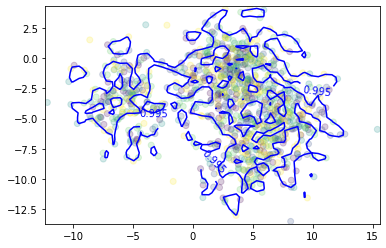

In [18]:
best_clf = debug_model
print(f'c: {best_clf.c}, q: {best_clf.q}')

gx = np.linspace(min(X[:,0])-.2, max(X[:,0])+.2, 50)
gy = np.linspace(min(X[:,1])-.2, max(X[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([best_clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(best_clf.radius_, ), colors='blue')
plt.clabel(membership_contour, inline=1)

plt.scatter(X[:,0], X[:,1], c=colors, alpha=.2)
plt.show()

In [19]:
print(f'Mistakes {mistakes[-1]}/{len(X)} = {mistakes[-1]/len(X)*100}%')

Mistakes 284/1000 = 28.4%


Does the number of mistakes decrease from round to round?

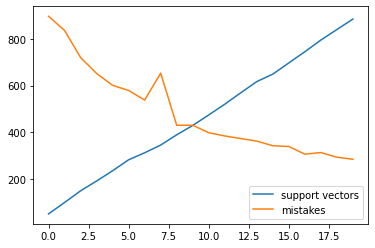

In [20]:
plt.plot([len(s['betas']) for s in debug_models], label='support vectors')
plt.plot(mistakes, label='mistakes')
plt.legend()
plt.show()

It seems that the federated approach ends up having less support vectors and does some extra mistake.
In this scenario we are seeing the data only once, so to avoid overfit.